In [3]:
# goal is to make multilayer perceptron that, given a simple two polymer (2 monomer each) binary mix, can predict 
#whether the system will micro or macro phase separate

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
import wlcstat.wlcstruc as wlcstruc

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

pset=propagator.prop_set(nlam=10) 

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [11]:
def calc_monomer_matrix(poly_mat, dens):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) > 1.001 or np.sum(dens) < 0.999):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly == alph1)
        sig2 = 1*(poly == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA

def calc_sf2(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(2) AA AB BB for a range of k
    M2_AA = calc_monomer_matrix(poly_mat, dens)
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)

    one = np.ones((M,M))
    grid = np.indices((M, M))
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr_fast = np.zeros(nk)
    S2_BB_arr_fast = np.zeros(nk)


    H_AA = np.diag(M2_AA)
    H_AA_mat = (H_AA * one).T
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

        np.fill_diagonal(C, np.diag(one * debye))

        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        #j1 > j2
        j1minusj2_mat = grid[0] - grid[1]
        C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

        #j2 > j1
        j2minusj1_mat = -1 * j1minusj2_mat
        C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
        
        
        S2_AA_arr[i] = np.sum(C * M2_AA)


        C_AB = H_AA_mat * C
        S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
        S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)
    return (S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast)

def calc_sf2_inv(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_arr, S2_AB_arr, S2_BB_arr) = calc_sf2(poly_mat, dens, N_m, b, k_vec)
    det = S2_AA_arr * S2_BB_arr - S2_AB_arr**2
    S2_AA_inv = S2_BB_arr * (1/det)
    S2_AB_inv = -S2_AB_arr * (1/det)
    S2_BB_inv = S2_AA_arr * (1/det)
    return (S2_AA_inv, S2_AB_inv, S2_BB_inv)

def find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, k_vec)
    G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

    # eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = G2
    min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

    k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 
    return k_star

In [37]:
#get data

diblocks = np.array([[0, 1], [0, 1]])
diblocks_dens = [0.5, 0.5]
diblocks_res = 1*(0.01 == find_kstar(diblocks, diblocks_dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)))

homos = np.array([[1, 1], [0, 0]])
homos_dens = diblocks_dens
homos_res = 1*(0.01 == find_kstar(homos, homos_dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)))

diblock_homo = np.array([[1, 1], [1, 0]])
d_arr = np.arange(0.1, 0.91, 0.01)

# dens = np.array([d, 1-d])
# testres = 1*(0.01 == find_kstar(diblock_homo, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)))

In [41]:
r1 = np.append(np.append(diblocks.flatten(), diblocks_dens), diblocks_res)
r2 = np.append(np.append(homos.flatten(), homos_dens), homos_res)
data = np.vstack((r1, r2))

for d in d_arr:
    dens = np.array([d, 1-d])
    res = 1*(0.01 == find_kstar(diblock_homo, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)))
    rn = np.append(np.append(diblock_homo.flatten(), dens) , res)
    data = np.vstack((data, rn))
#[p1m1 p1m2 p2m1 p2m2 p1d1 p2d2 macro?]

In [42]:
data
#clms: [p1m1 p1m2 p2m1 p2m2 p1d1 p2d2 macro?]

array([[0. , 1. , 0. , 1. , 0.5, 0.5, 0. ],
       [1. , 1. , 0. , 0. , 0.5, 0.5, 1. ],
       [1. , 1. , 1. , 0. , 0.1, 0.9, 0. ],
       [1. , 1. , 1. , 0. , 0.2, 0.8, 0. ],
       [1. , 1. , 1. , 0. , 0.3, 0.7, 0. ],
       [1. , 1. , 1. , 0. , 0.4, 0.6, 0. ],
       [1. , 1. , 1. , 0. , 0.5, 0.5, 1. ],
       [1. , 1. , 1. , 0. , 0.6, 0.4, 1. ],
       [1. , 1. , 1. , 0. , 0.7, 0.3, 1. ],
       [1. , 1. , 1. , 0. , 0.8, 0.2, 1. ],
       [1. , 1. , 1. , 0. , 0.9, 0.1, 1. ]])

In [49]:
X = data[:,0:-1]
X

array([[0. , 1. , 0. , 1. , 0.5, 0.5],
       [1. , 1. , 0. , 0. , 0.5, 0.5],
       [1. , 1. , 1. , 0. , 0.1, 0.9],
       [1. , 1. , 1. , 0. , 0.2, 0.8],
       [1. , 1. , 1. , 0. , 0.3, 0.7],
       [1. , 1. , 1. , 0. , 0.4, 0.6],
       [1. , 1. , 1. , 0. , 0.5, 0.5],
       [1. , 1. , 1. , 0. , 0.6, 0.4],
       [1. , 1. , 1. , 0. , 0.7, 0.3],
       [1. , 1. , 1. , 0. , 0.8, 0.2],
       [1. , 1. , 1. , 0. , 0.9, 0.1]])

In [51]:
y = data[:,-1]
y

array([0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

In [52]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.2)

In [53]:
X_train

array([[1. , 1. , 1. , 0. , 0.8, 0.2],
       [1. , 1. , 0. , 0. , 0.5, 0.5],
       [1. , 1. , 1. , 0. , 0.5, 0.5],
       [0. , 1. , 0. , 1. , 0.5, 0.5],
       [1. , 1. , 1. , 0. , 0.6, 0.4],
       [1. , 1. , 1. , 0. , 0.9, 0.1],
       [1. , 1. , 1. , 0. , 0.7, 0.3],
       [1. , 1. , 1. , 0. , 0.4, 0.6]])

In [54]:
#train model
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, y_train)

In [55]:
y_pred=clf.predict(X_test)

In [57]:
X_test

array([[1. , 1. , 1. , 0. , 0.1, 0.9],
       [1. , 1. , 1. , 0. , 0.2, 0.8],
       [1. , 1. , 1. , 0. , 0.3, 0.7]])

In [56]:
y_pred

array([0., 0., 0.])

In [ ]:
#test model!!

In [58]:
print(clf.score(X_test, y_test))

1.0


In [60]:
clf.predict([[1, 1, 1, 0, 0.2343, 1- .2343]])

array([0.])

# Random polymers

In [94]:
# want more complex model which can handle a mix of 10 dif random polyms of size 10 monomers

In [155]:
# for one mix
N_m = 1# length of monomer
b = 1# kuhn length
M = 10# number of monomers per polymer
n_p = 10# number of polymer types per mix
n_mixs = 100000# number of mixes

rand_polys = np.random.choice(2,(n_mixs, n_p, M))
rand_dens = np.random.dirichlet(np.ones(n_p),size=(1, n_mixs))[0]

In [156]:
%%time
data = np.array([])
for i, mix in enumerate(rand_polys):
    dens = rand_dens[i]
    res = 1*(0.01 == find_kstar(mix, dens, N_m, b))  # 1 means macro, 0 means micro
    
    row = np.append(np.append(mix.flatten(), dens) , res)
    if len(data) == 0:
        data = row
    else:
        data = np.vstack((data, row))

Wall time: 39min 17s


In [157]:
X = data[:,0:-1]
# X
y = data[:,-1]
# y  # 1 means macrophase seperation, 0 means micro

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.2)

In [161]:
%%time
#train model
# clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, y_train)
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, y_train)

# clf = MLPClassifier(hidden_layer_sizes=(32,32),activation="relu",random_state=1).fit(X_train, y_train) #BEST of tj

Wall time: 9min 30s


In [159]:
# y_pred=clf.predict(X_test)

#32 32 mlp
#test model!!
print(clf.score(X_test, y_test))

0.7708


In [160]:
#32 32 mlp
clf.score(X_train, y_train)

0.8248125

In [162]:
# y_pred=clf.predict(X_test)

#4 layer mlp
#test model!!
print(clf.score(X_test, y_test))

0.7543


In [163]:
#4 layer mlp
clf.score(X_train, y_train)

0.9954

#### conclusions

- the best neural net architecture (not overfit, test and train have similar accuracy) is two layer 32 32 

- to speed up analysis, can do curvature of G2 analysis at k = 0. If second derivative > 0, then micro; if second derivative < 0, 
    then macro. Do taylor expansion, then double derive and set k = 0 
    
    Taylor expansion for homopolymer in lecture 4. can extend by multiplying monomer cross correlation matrix. 
    
    ? - can you sum over M(2) and <r-r> separately?
    

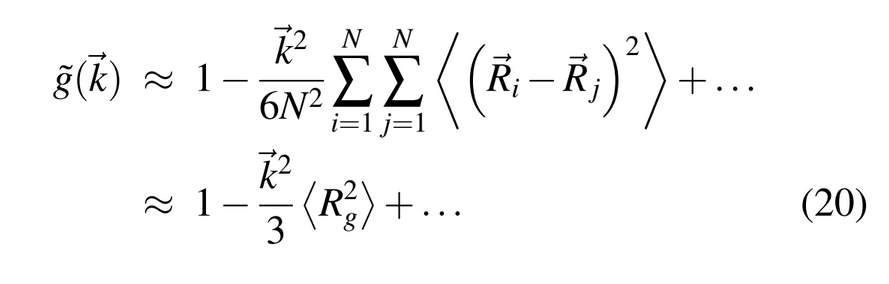

In [ ]:
# 

In [ ]:
[[ 0,0 ; 0,1 ], 
 [ 1,0 ; 1,1 ]]

r00*m00 + r01*m01 + r10*m10 + r11*m11 != (r00 + r01 + r10 + r11) * (m00 + m01 + m10 + m11)

# how to do sum over r delta when dont have monomer positions
# confusion- cross correlation is only ever positive. So, changing polymer ensemble would only change the magnitude of
# the low-k structure factor. Could then change sign of G2 double derivative

# possibly ignore del R?? doesnt matter

In [108]:
# clf.predict([[1, 1, 1, 0, 0.2343, 1- .2343]])

In [109]:
# test model by hand on basic diblock and homopolymer systems